# Case Study: Automated Machine Learning (AutoML) for Autonomous Intrusion Detection System Development 
This is the code for the paper entitled "**[Enabling AutoML for Zero-Touch Network Security: Use-Case Driven Analysis](https://ieeexplore.ieee.org/document/10472316)**" published in *IEEE Transactions on Network and Service Management* (IF:5.3).<br>
Authors: Li Yang (liyanghart@gmail.com), Mirna El Rajab, Abdallah Shami, and Sami Muhaidat<br>

L. Yang, M. E. Rajab, A. Shami, and S. Muhaidat, "Enabling AutoML for Zero-Touch Network Security: Use-Case Driven Analysis," IEEE Transactions on Network and Service Management, pp. 1-28, 2024, doi: https://doi.org/10.1109/TNSM.2024.3376631.

# Code Part 2: Automated Online Learning (Dynamic Data Stream Analytics)
Online learning: Online learning techniques are able to train models using continuously incoming online data streams in dynamic environments. By learning a single data sample at a time, online learning models can reduce memory requirements for data storage and learn new data patterns. Additionally, online learning models can often achieve real-time processing and address concept drift issues. Thus, when applied to dynamic data streams or when inadequate data is available, online learning is often more effective than batch learning.

## Dataset 2: 5G-NIDD
A subset of the network traffic data randomly sampled from the [5G-NIDD dataset](https://ieee-dataport.org/documents/5g-nidd-comprehensive-network-intrusion-detection-dataset-generated-over-5g-wireless).  

The 5G-NIDD dataset, created in December 2022, is a fully labeled resource constructed on a functional 5G test network for researchers and practitioners evaluating AI/ML solutions in the context of 5G/6G security [87]. 5G-NIDD encompasses data extracted from a 5G testbed connected to the 5G Test Network (5GTN) at the University of Oulu, Finland. The dataset is derived from two base stations, each featuring an attacker node and multiple benign 5G users. The attacker nodes target a server deployed within the 5GTN MEC environment. The attack scenarios captured in the dataset primarily include DoS attacks and port scans.

## Import libraries

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from scipy.stats import shapiro
from imblearn.over_sampling import SMOTE, ADASYN
import time

In [68]:
import warnings 
warnings.filterwarnings('ignore')

## Read the sampled 5G-NIDD dataset

In [69]:
df = pd.read_csv("Data/5gnidd_0.01_pre-processed.csv")

In [70]:
df

,Seq,Dur,RunTime,Mean,Sum,Min,Max,Proto,sTos,dTos,...,SrcWin,DstWin,sVid,dVid,SrcTCPBase,DstTCPBase,TcpRtt,SynAck,AckDat,Label
0,0.000496,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.75,0.000000,0.000000,...,0.000002,0.00000,0.0,0.0,0.388654,0.000000,0.0,0.0,0.0,1
1,0.002442,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.75,0.000000,0.000000,...,0.000000,0.00000,0.0,0.0,0.388654,0.000000,0.0,0.0,0.0,1
2,0.003295,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.75,0.000000,0.000000,...,0.000000,0.00000,0.0,0.0,0.388654,0.000000,0.0,0.0,0.0,1
3,0.003317,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.75,0.000000,0.000000,...,0.000000,0.00000,0.0,0.0,0.388654,0.000000,0.0,0.0,0.0,1
4,0.003375,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.75,0.000000,0.000000,...,0.000000,0.00000,0.0,0.0,0.388669,0.000000,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12154,0.003688,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.00,0.000000,0.000000,...,0.000000,0.00000,1.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0
12155,0.004104,2.000005e-07,2.000005e-07,2.000005e-07,2.000005e-07,2.000005e-07,2.000005e-07,0.75,0.000000,0.000000,...,0.000008,0.00025,0.0,0.0,0.292755,0.030151,0.0,0.0,0.0,0
12156,0.005234,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.00,0.000000,0.000000,...,0.000000,0.00000,1.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0
12157,0.000015,4.079091e-02,4.079091e-02,4.079091e-02,4.079091e-02,4.079091e-02,4.079091e-02,0.50,0.830357,0.215054,...,0.000000,0.00000,0.0,1.0,0.000000,0.000000,0.0,0.0,0.0,0


# 1. Automated Data Pre-Processing

## Automated Transformation/Encoding
Automatically identify and transform string/text features into numerical features to make the data more readable by ML models

In [71]:
# Define the automated data encoding function
def Auto_Encoding(df):
    cat_features=[x for x in df.columns if df[x].dtype=="object"] ## Find string/text features
    le=LabelEncoder()
    for col in cat_features:
        if col in df.columns:
            i = df.columns.get_loc(col)
            # Transform to numerical features
            df.iloc[:,i] = df.apply(lambda i:le.fit_transform(i.astype(str)), axis=0, result_type='expand')
    return df

In [72]:
df=Auto_Encoding(df)

## Automated normalization
Normalize the range of features to a similar scale to improve data quality

In [73]:
def Auto_Normalization(df):
    stat, p = shapiro(df)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    numeric_features = df.drop(['Label'],axis = 1).dtypes[df.dtypes != 'object'].index
    
    # check if the data distribution follows a Gaussian/normal distribution
    # If so, select the Z-score normalization method; otherwise, select the min-max normalization
    # Details are in the paper
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
        df[numeric_features] = df[numeric_features].apply(
            lambda x: (x - x.mean()) / (x.std()))
        print('Z-score normalization is automatically chosen and used')
    else:
        print('Sample does not look Gaussian (reject H0)')
        df[numeric_features] = df[numeric_features].apply(
            lambda x: (x - x.min()) / (x.max()-x.min()))
        print('Min-max normalization is automatically chosen and used')
    return df

In [74]:
df=Auto_Normalization(df)

Statistics=0.563, p=0.000
Sample does not look Gaussian (reject H0)
Min-max normalization is automatically chosen and used


## Automated Imputation
Detect and impute missing values to improve data quality

In [75]:
# Define the automated data imputation function
def Auto_Imputation(df):
    # Replace infinities with NaN to unify the treatment of missing data
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Identify numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    # Apply imputation only if necessary
    if df[numeric_cols].isnull().values.any():
        for col in numeric_cols:
            # Check if the entire column is NaN
            if df[col].isna().all():
                # Optional: fill such columns with a placeholder value or drop them
                # Here, we choose to fill with 0 as an example
                df[col].fillna(0, inplace=True)
            else:
                # Apply median imputation
                df[col].fillna(df[col].median(), inplace=True)
    
    # Final check for NaN or infinite values in numeric columns
    if df[numeric_cols].isnull().any().any() or np.isinf(df[numeric_cols].values).any():
        raise ValueError("Numeric data still contains NaN, infinity or a value too large after imputation.")
    
    return df


In [76]:
df=Auto_Imputation(df)

# 2. Automated Feature Engineering
Feature selection method 1: **Recursive Feature Elimination (RFE)**, used to remove irrelevant features to improve model efficiency  
Feature selection method 2: **Pearson Correlation**, used to remove redundant features to improve model efficiency and accuracy  

In [77]:
# Remove irrelevant features and select important features
def Feature_Importance_RFE(data, n_features_to_select=20):
    features = data.drop(['Label'], axis=1).values  # "Label" should be changed to the target class variable name if different
    labels = data['Label'].values

    # Extract feature names
    feature_names = list(data.drop(['Label'], axis=1).columns)

    # Create a base estimator
    model = lgb.LGBMRegressor(verbose = -1)

    # Create the RFE object and rank each feature
    rfe = RFE(estimator=model, n_features_to_select=n_features_to_select, step=1)
    rfe.fit(features, labels)

    # Get the feature ranking
    feature_ranking = rfe.ranking_

    # Create a DataFrame for feature importances
    feature_importances = pd.DataFrame({'feature': feature_names, 'ranking': feature_ranking})

    # Sort features according to their ranking
    feature_importances = feature_importances.sort_values('ranking', ascending=True).reset_index(drop=True)

    # Get the features to drop
    to_drop = list(feature_importances[feature_importances['ranking'] > 1]['feature'])

    return to_drop

In [78]:
# Remove redundant features
def Feature_Redundancy_Pearson(data):
    correlation_threshold=0.90 # Only remove features with the redundancy>90%. It can be changed
    features = data.drop(['Label'],axis=1)
    corr_matrix = features.corr()

    # Extract the upper triangle of the correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))

    # Select the features with correlations above the threshold
    # Need to use the absolute value
    to_drop = [column for column in upper.columns if any(upper[column].abs() > correlation_threshold)]

    # Dataframe to hold correlated pairs
    record_collinear = pd.DataFrame(columns = ['drop_feature', 'corr_feature', 'corr_value'])

    # Iterate through the columns to drop
    for column in to_drop:

        # Find the correlated features
        corr_features = list(upper.index[upper[column].abs() > correlation_threshold])

        # Find the correlated values
        corr_values = list(upper[column][upper[column].abs() > correlation_threshold])
        drop_features = [column for _ in range(len(corr_features))]    

        # Record the information (need a temp df for now)
        temp_df = pd.DataFrame.from_dict({'drop_feature': drop_features,
                                         'corr_feature': corr_features,
                                         'corr_value': corr_values})
        record_collinear = record_collinear.append(temp_df, ignore_index = True)
#     print(record_collinear)
    return to_drop

In [79]:
def Auto_Feature_Engineering(df):
    drop1 = Feature_Importance_RFE(df)
    dfh1 = df.drop(columns = drop1)
    
    drop2 = Feature_Redundancy_Pearson(dfh1)
    dfh2 = dfh1.drop(columns = drop2)
    
    return dfh2

In [80]:
dfh2 = Auto_Feature_Engineering(df)
dfh2

,Seq,Dur,Proto,sTtl,dTtl,sHops,TotBytes,SrcBytes,Offset,sMeanPktSz,...,Load,pLoss,Rate,SrcWin,DstWin,SrcTCPBase,TcpRtt,SynAck,AckDat,Label
0,0.000496,0.000000e+00,0.75,0.211765,0.000000,0.357143,0.000007,0.000092,0.000201,0.042208,...,0.000000,0.0,0.000000,0.000002,0.00000,0.388654,0.0,0.0,0.0,1
1,0.002442,0.000000e+00,0.75,0.145098,0.000000,0.964286,0.000007,0.000092,0.000850,0.042208,...,0.000000,0.0,0.000000,0.000000,0.00000,0.388654,0.0,0.0,0.0,1
2,0.003295,0.000000e+00,0.75,0.149020,0.000000,0.928571,0.000007,0.000092,0.001133,0.042208,...,0.000000,0.0,0.000000,0.000000,0.00000,0.388654,0.0,0.0,0.0,1
3,0.003317,0.000000e+00,0.75,0.211765,0.000000,0.357143,0.000007,0.000092,0.001140,0.042208,...,0.000000,0.0,0.000000,0.000000,0.00000,0.388654,0.0,0.0,0.0,1
4,0.003375,0.000000e+00,0.75,0.211765,0.000000,0.357143,0.000007,0.000092,0.001160,0.042208,...,0.000000,0.0,0.000000,0.000000,0.00000,0.388669,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12154,0.003688,0.000000e+00,1.00,0.976471,0.000000,0.250000,0.000014,0.000117,0.003075,0.053852,...,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0
12155,0.004104,2.000005e-07,0.75,0.203922,0.250980,0.428571,0.000158,0.000257,0.003462,0.039298,...,0.557175,0.0,1.000000,0.000008,0.00025,0.292755,0.0,0.0,0.0,0
12156,0.005234,0.000000e+00,1.00,0.976471,0.000000,0.250000,0.000014,0.000117,0.004298,0.053852,...,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0
12157,0.000015,4.079091e-02,0.50,1.000000,0.980392,0.035714,0.000145,0.000304,0.004546,0.069862,...,0.000002,0.0,0.000003,0.000000,0.00000,0.000000,0.0,0.0,0.0,0


## Train-test split
Split the dataset into the training and the test set   

Here we used the 1%/99% split, because for online learning, the initial available data would only be a small percentage, and the incoming data streams will be continously learned by the data analytics models. It can be changed based on specific tasks

In [81]:
X = dfh2.drop(['Label'],axis=1)
y = dfh2['Label']

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.01, test_size = 0.99, shuffle=False,random_state = 0)

## Automated data balancing
Generate minority class samples to solve class-imbalance and improve data quality.  
Synthetic Minority Over-sampling Technique (SMOTE) method is used.

In [82]:
pd.Series(y_train).value_counts()

1    109
0     12
Name: Label, dtype: int64

In [83]:
# For binary data (can be modified for multi-class data with the same logic)
def Auto_Balancing(X_train, y_train):
    number0 = pd.Series(y_train).value_counts().iloc[0]
    number1 = pd.Series(y_train).value_counts().iloc[1]
    
    if number0 > number1:
        nlarge = number0
    else:
        nlarge = number1
    
    # evaluate whether the incoming dataset is imbalanced (the abnormal/normal ratio is smaller than a threshold (e.g., 50%)) 
    if (number1/number0 > 1.5) or (number0/number1 > 1.5):
        balanced=ADASYN(n_jobs=-1,sampling_strategy={0:nlarge, 1:nlarge})

        X_train, y_train = balanced.fit_resample(X_train, y_train)
        
    return X_train, y_train

In [84]:
X_train, y_train = Auto_Balancing(X_train, y_train)

In [85]:
pd.Series(y_train).value_counts()

1    109
0    108
Name: Label, dtype: int64

# 3. Model Learning

Four state-of-the-art online learners: 
* Hoeffding Tree (HT)
* Leveraging Bagging (LB)
* Adaptive Random Forest (ARF) 
* Streaming Random Patches (SRP)


An offline learner for comparison:
* LightGBM


## Static Model learning: LightGBM (for Comparison)

              precision    recall  f1-score   support

           0       0.29      0.17      0.22      4731
           1       0.58      0.73      0.64      7307

    accuracy                           0.51     12038
   macro avg       0.43      0.45      0.43     12038
weighted avg       0.46      0.51      0.48     12038

Accuracy: 50.946999999999996%
Precision: 57.587999999999994%
Recall: 72.807%
F1-score: 64.30900000000001%


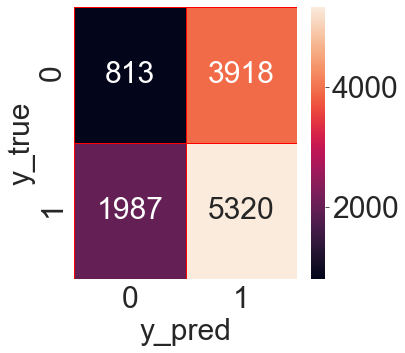

Wall time: 191 ms


In [86]:
%%time
# LightGBM algorithm
import lightgbm as lgb
classifier = lgb.LGBMClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(classification_report(y_test,y_pred))
print("Accuracy: "+str(round(accuracy_score(y_test, y_pred),5)*100)+"%")
print("Precision: "+str(round(precision_score(y_test, y_pred),5)*100)+"%")
print("Recall: "+str(round(recall_score(y_test, y_pred),5)*100)+"%")
print("F1-score: "+str(round(f1_score(y_test, y_pred),5)*100)+"%")

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

The accuracy of the static LightGBM model is very low (83.958%), due to the occurance of concept drift (data distribution changes). Therefore, online learning methods that can adapt to concept drift issues should be developed for dynamic data stream analytics.

## Online Learning

In [87]:
# Import the online learning metrics and algorithms from the River library
import river
from river import metrics
from river import stream
from river import tree,neighbors,naive_bayes,ensemble,linear_model
from river.drift import DDM, EDDM, ADWIN

In [88]:
# Define a generic adaptive learning function
# The argument "model" means an online adaptive learning algorithm
def adaptive_learning(model, X_train, y_train, X_test, y_test):
    metric = metrics.Accuracy() # Use accuracy as the metric
    i = 0 # count the number of evaluated data points
    t = [] # record the number of evaluated data points
    m = [] # record the real-time accuracy
    yt = [] # record all the true labels of the test set
    yp = [] # record all the predicted labels of the test set

    # Learn the training set
    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        model.learn_one(xi1,yi1) 

    # Predict the test set
    for xi, yi in stream.iter_pandas(X_test, y_test):
        y_pred= model.predict_one(xi)  # Predict the test sample
        model.learn_one(xi,yi) # Learn the test sample
        metric = metric.update(yi, y_pred) # Update the real-time accuracy
        t.append(i)
        m.append(metric.get()*100)
        yt.append(yi)
        yp.append(y_pred)
        i = i+1
    print("Accuracy: "+str(round(accuracy_score(yt,yp),5)*100)+"%")
    print("Precision: "+str(round(precision_score(yt,yp),5)*100)+"%")
    print("Recall: "+str(round(recall_score(yt,yp),5)*100)+"%")
    print("F1-score: "+str(round(f1_score(yt,yp),5)*100)+"%")
    return t, m

In [89]:
# Define a figure function that shows the real-time accuracy changes
def acc_fig(t, m, name):
    plt.rcParams.update({'font.size': 15})
    plt.figure(1,figsize=(10,6)) 
    sns.set_style("darkgrid")
    plt.clf() 
    plt.plot(t,m,'-b',label='Avg Accuracy: %.2f%%'%(m[-1]))

    plt.legend(loc='best')
    plt.title(name+' on 5G-NIDD dataset', fontsize=15)
    plt.xlabel('Number of samples')
    plt.ylabel('Accuracy (%)')

    plt.draw()

Accuracy: 96.877%
Precision: 98.625%
Recall: 96.195%
F1-score: 97.395%
Wall time: 2.89 s


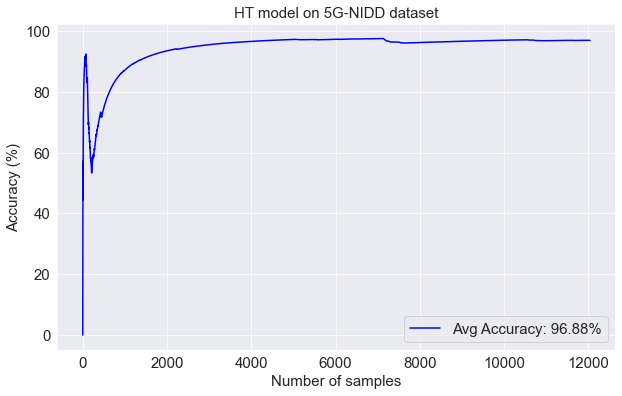

In [90]:
%%time
# Use the Hoeffding Tree (HT) model 
name1 = "HT model"
model1 = tree.HoeffdingTreeClassifier() # Define the model
t, m1 = adaptive_learning(model1, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m1, name1) # Draw the figure of how the real-time accuracy changes with the number of samples

Accuracy: 98.762%
Precision: 98.39099999999999%
Recall: 99.589%
F1-score: 98.98700000000001%
Wall time: 3.66 s


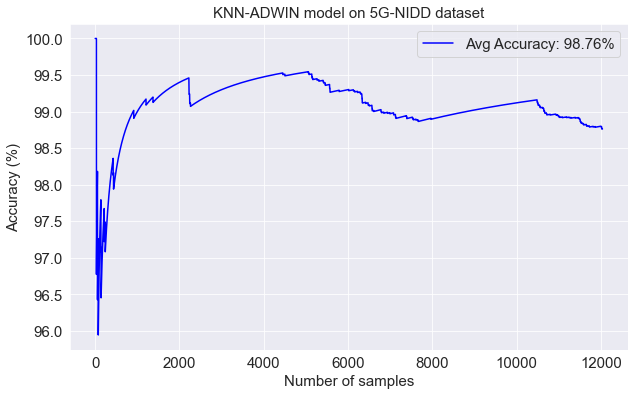

In [91]:
%%time
# Use the K-Nearest Neighbors (KNN) classifier with ADWIN change detector
name2 = "KNN-ADWIN model"
model2 = neighbors.KNNADWINClassifier(window_size=100) # Define the model
t, m2 = adaptive_learning(model2, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m2, name2) # Draw the figure of how the real-time accuracy changes with the number of samples

Accuracy: 98.97%
Precision: 99.259%
Recall: 99.042%
F1-score: 99.151%
Wall time: 6.36 s


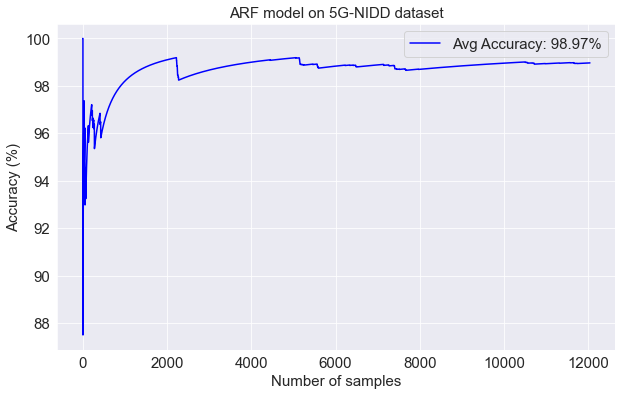

In [92]:
%%time
# Use the Adaptive Random Forest (ARF) model
name3 = "ARF model"
model3 = ensemble.AdaptiveRandomForestClassifier(n_models = 3) # Define the model
t, m3 = adaptive_learning(model3, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m3, name3) # Draw the figure of how the real-time accuracy changes with the number of samples

Accuracy: 99.327%
Precision: 99.344%
Recall: 99.548%
F1-score: 99.446%
Wall time: 9.8 s


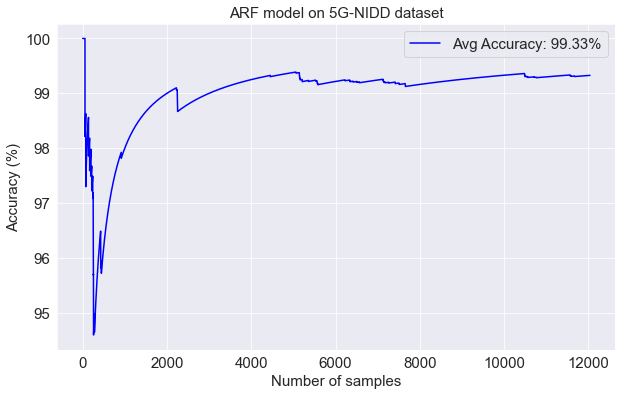

In [93]:
%%time
# Use the Adaptive Random Forest (ARF) model
name32 = "ARF model"
model32 = ensemble.AdaptiveRandomForestClassifier(n_models = 4) # Define the model
t, m32 = adaptive_learning(model32, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m32, name32) # Draw the figure of how the real-time accuracy changes with the number of samples

Accuracy: 99.419%
Precision: 99.453%
Recall: 99.589%
F1-score: 99.521%
Wall time: 26.9 s


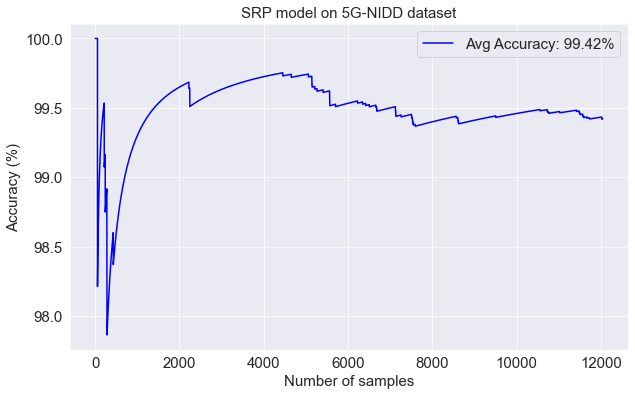

In [94]:
%%time
# Use the Streaming Random Patches (SRP) model with ADWIN drift detector
name4 = "SRP model"
model4 = ensemble.SRPClassifier(n_models = 3) # Define the model
t, m4 = adaptive_learning(model4, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m4, name4) # Draw the figure of how the real-time accuracy changes with the number of samples

Accuracy: 99.52600000000001%
Precision: 99.562%
Recall: 99.658%
F1-score: 99.61%
Wall time: 1min 10s


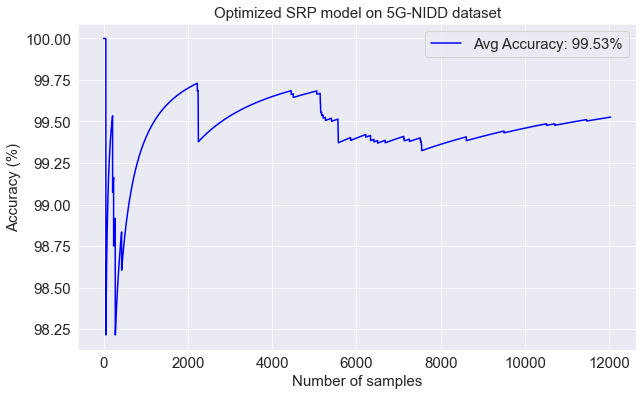

In [95]:
%%time
# Use the Streaming Random Patches (SRP) model with ADWIN drift detector
name5 = "Optimized SRP model"
model5 = ensemble.SRPClassifier(n_models = 8) # Define the model
t, m5 = adaptive_learning(model5, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m5, name5) # Draw the figure of how the real-time accuracy changes with the number of samples

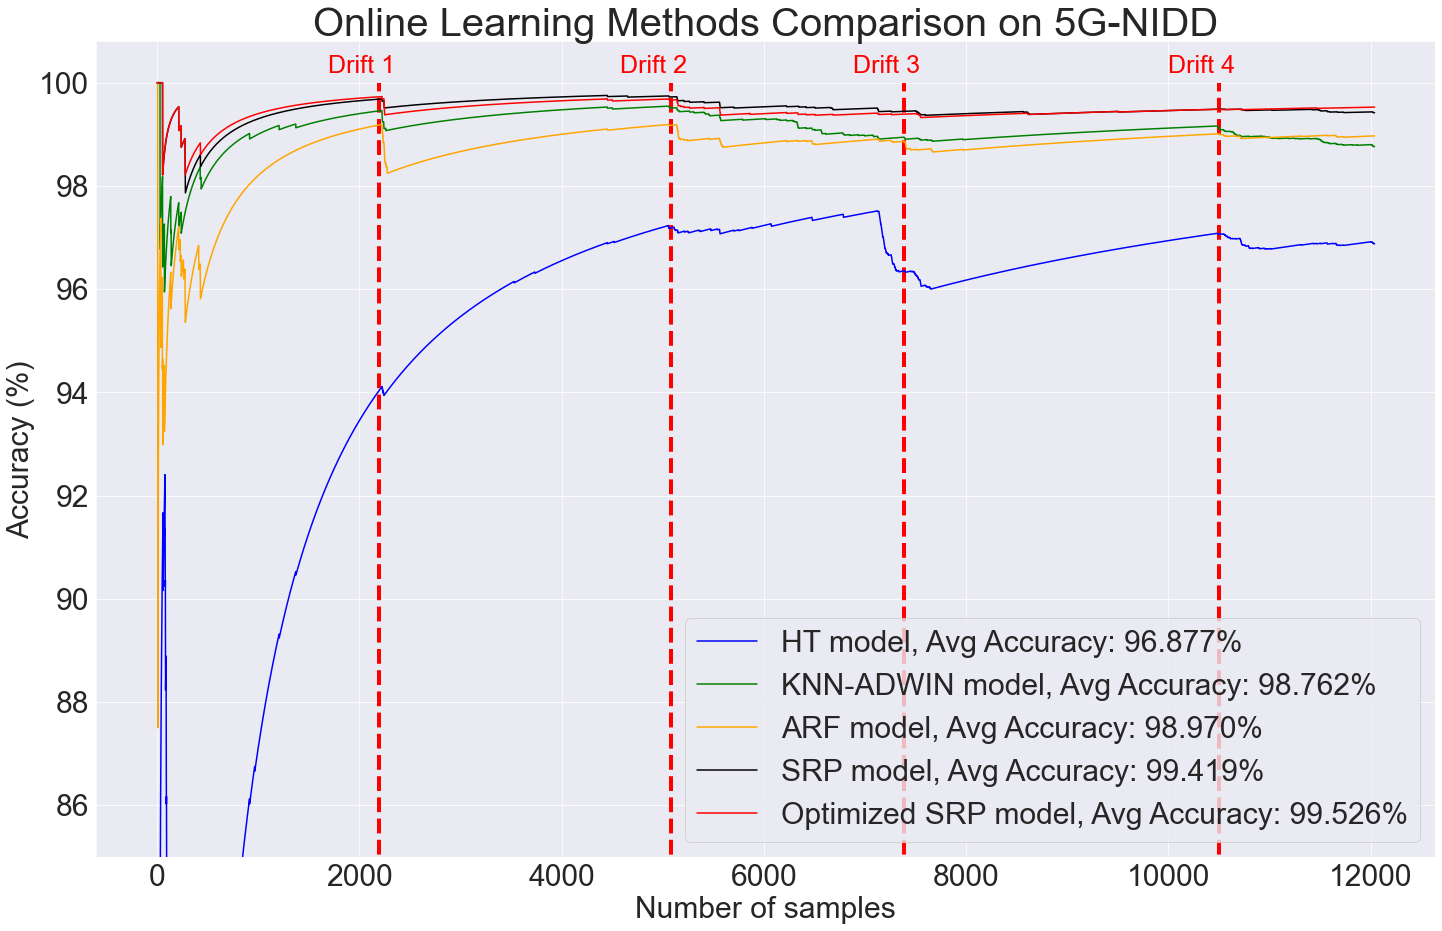

In [96]:
# Draw a comprehensive figure to compare the performance of all models
plt.rcParams.update({'font.size': 30})
plt.figure(1,figsize=(24,15)) 
sns.set_style("darkgrid")
plt.clf() 

# Plot the accuracy change of each learner
plt.plot(t,m1,'-b',label=name1+', Avg Accuracy: %.3f%%'%(m1[-1]))
plt.plot(t,m2,'-g',label=name2+', Avg Accuracy: %.3f%%'%(m2[-1]))
plt.plot(t,m3,'orange',label=name3+', Avg Accuracy: %.3f%%'%(m3[-1]))
plt.plot(t,m4,'black',label=name4+', Avg Accuracy: %.3f%%'%(m4[-1]))
plt.plot(t,m5,'red',label=name5+', Avg Accuracy: %.3f%%'%(m5[-1]))

# Draw the drift points/time
dr = [0,2190,5080,7380,10500]
for i in range(len(dr)):
    if i!=0:
        plt.text(dr[i]-500, 100.2, 'Drift '+str(i), c = "red", fontsize = 25)
        plt.vlines(dr[i], 0, 100, colors = "red", linewidth=4, linestyles = "dashed")
        
plt.legend(loc='lower right')
plt.ylim(85, 100.8)
plt.title('Online Learning Methods Comparison on 5G-NIDD', fontsize=40)
plt.xlabel('Number of samples')
plt.ylabel('Accuracy (%)')

plt.draw()